## Older Data Analysis##

At this point, we have successfully analyzed 1 full data set using the CPE: A $CdCl_{2}$-capped PbS film in a ZnO pn junction. The analysis is summarized nicely in the 'FullTempAnalysis.ipynb'. 

However, when we try to apply this analysis to solar cells with very distinct reverse or 0 bias capacitance responses for the PbS layer and the ZnO layer, we see the appearance of multiple Rc arcs **and** a high frequency diffusion element. Clearly, our very simple circuit model cannot take all of these dynamics into effect. 

While it's clear that these data need a more complicated model, likely adding in a diffusion element and 1 or more CPE RC elements in series with the one we already used, let's how far we can extend the simple model. First, let's look at the forward biased data corresponding to a solar cell with a TAS spectra that more or less resembles the 0-bias TAS data of the $CdCl_{2}$ already analyzed. If our simple model applies to this data somewhat well, than there may be some truth to our hypothesis about the ZnO and PbS layer blending together into a shitty dielectric with a broad distribution of RC time constants. If our model fails to apply to even this data, then maybe what we observed was a fluke.

The data we consider here is from **February, 2016**. It comes from the reference data of a white light soaked sample. Note that this sample *is not $CdCl_{2}$ capped.* The full dataset has been copied into the directory specified below. The original path of the data is the following:

**"C:\Users\Eric\Desktop\Lab_Work\admittance\illumination\illumination\white_light_soak\try2\reference"**


In [48]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [49]:
import numpy as np
import lmfit as lmf
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import os
%matplotlib inline

os.chdir('C:\\Users\\Eric\\Desktop\\Lab_Work\\impedance\\PbS-TBAI\\oldData\\WLS_2_ref\\data')

# os.listdir()
tmax = 19
T = np.linspace(150,150+(10*tmax),tmax,endpoint=False)
devNum = 2
voltage1 = 400
voltage2 = 500

nPoints = 201
master400mv = np.zeros((tmax,nPoints,5))
master500mv = np.zeros((tmax,nPoints,5))

is400 = np.zeros((tmax,nPoints,4))
is500 = np.zeros((tmax,nPoints,4))

# the tmp data has the following format:
#      index 0 is frequency in rad/s
#      index 1 is capacitance, C
#      index 2 is susceptance, B
#      index 3 is dissipation, D
#      index 4 is conductance, G

# we create arrays to hold the impedance data (isv1/isv2) with the following format:
#      index 0 is Re(Z) in kOhm*cm^2
#      index 1 is Im(Z) in kOhm*cm^2
#      index 2 is |Z| in kOhm*cm^2
#      index 3 is phase angle \phi in degrees

for t in range(0,tmax):
    file1 = 'dev' + str(devNum) + '_T' + np.array2string(T[t].astype(int)) +'K_Vbias' + str(voltage1) + 'mV_All_Modified.txt'     
    tmp1 = np.genfromtxt(file1)
    master400mv[t,:,0] = tmp1[1:,0]
    master400mv[t,:,1] = savitzky_golay(tmp1[1:,1],51,5)
    master400mv[t,:,2] = savitzky_golay(tmp1[1:,2],51,5)
    master400mv[t,:,3] = savitzky_golay(tmp1[1:,3],51,5)
    master400mv[t,:,4] = savitzky_golay(tmp1[1:,4],51,5)

    is400[t,:,0] = ((master400mv[t,:,4]/((master400mv[t,:,4]**2) + (master400mv[t,:,2]**2)))*4e-2)/1e3
    is400[t,:,1] = ((-master400mv[t,:,2]/((master400mv[t,:,4]**2) + (master400mv[t,:,2]**2)))*4e-2)/1e3
    is400[t,:,2] = np.sqrt((is400[t,:,0]**2) + (is400[t,:,1]**2))
    is400[t,:,3] = -np.arctan(is400[t,:,1]/is400[t,:,0])*(180/np.pi)
                           
        
    file2 = 'dev' + str(devNum) + '_T' + np.array2string(T[t].astype(int)) +'K_Vbias' + str(voltage2) + 'mV_All_Modified.txt'     
    tmp2 = np.genfromtxt(file2)
    master500mv[t,:,0] = tmp2[1:,0]    
    master500mv[t,:,1] = savitzky_golay(tmp2[1:,1],51,5)
    master500mv[t,:,2] = savitzky_golay(tmp2[1:,2],51,5)
    master500mv[t,:,3] = savitzky_golay(tmp2[1:,3],51,5)
    master500mv[t,:,4] = savitzky_golay(tmp2[1:,4],51,5)

    is500[t,:,0] = ((master500mv[t,:,4]/((master500mv[t,:,4]**2) + (master500mv[t,:,2]**2)))*4e-2)/1e3
    is500[t,:,1] = ((-master500mv[t,:,2]/((master500mv[t,:,4]**2) + (master500mv[t,:,2]**2)))*4e-2)/1e3
    is500[t,:,2] = np.sqrt((is500[t,:,0]**2) + (is500[t,:,1]**2))
    is500[t,:,3] = -np.arctan(is500[t,:,1]/is500[t,:,0])*(180/np.pi)
    

# define some simple functions to make the analysis code a bit more concise
def Zr400(T):
    return is400[T,:,0]

def Zr500(T):
    return is500[T,:,0]

def Zi400(T):
    return is400[T,:,1]

def Zi500(T):
    return is500[T,:,1]

def Zmag400(T):
    return is400[T,:,2]

def Zmag500(T):
    return is500[T,:,2]

def phi400(T):
    return is400[T,:,3]

def phi500(T):
    return is500[T,:,3]

def w(T):
    return master400mv[t,:,0]

# input useful constants
kB = 8.617e-5

# make colormap
colSet = (cm.plasma(np.linspace(0,1,tmax)))

# indicate the figures directory
figDir = "C:\\Users\\Eric\\Desktop\\Lab_Work\\impedance\\PbS-TBAI\\oldData\\WLS_2_ref\\Analysis\\impedance"

# indicate offset, if any. tmin = 0 indicates no offset. otherwise, input another minumum temp to start analysis
tmin = 1



Let's first look at the 400mV data and see what the deal is. Look at the Nyqsuit, Bode, and Re(Z) and Im(Z) plots.

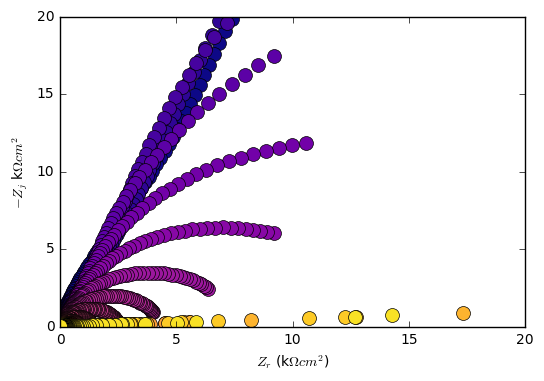

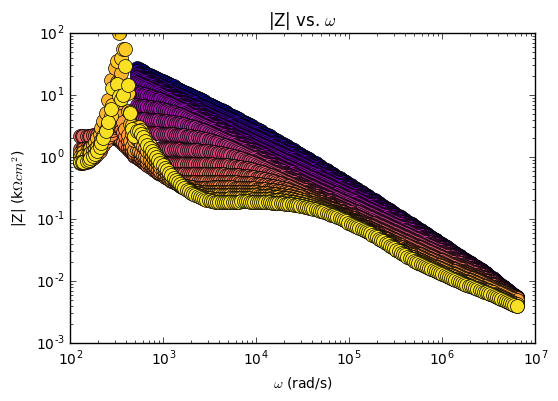

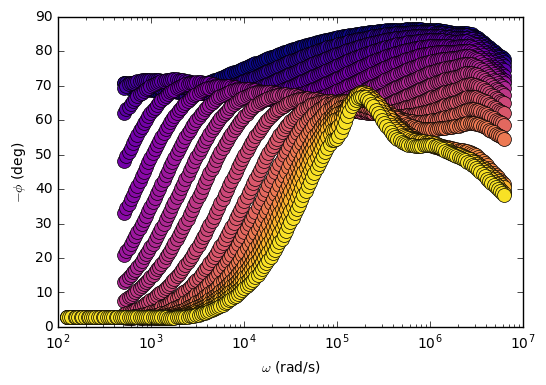

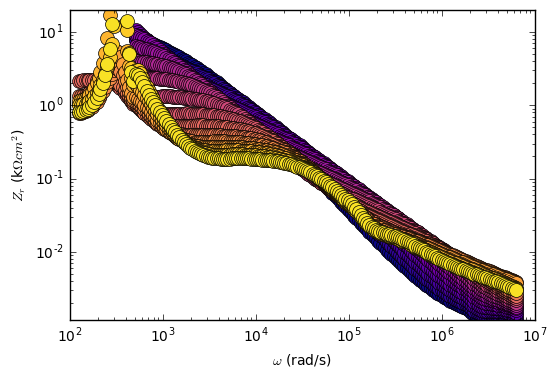

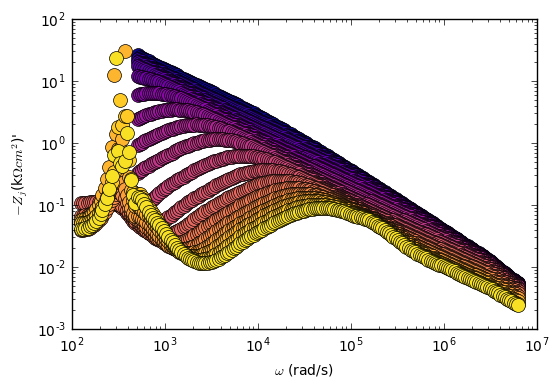

In [50]:
# Nyquist plots
fig,ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(Zr400(t),-Zi400(t),'o',c = c, markersize = 10)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{j}$ k$\Omega cm^{2}$")
ax.axis([0,20, 0,20])
# figName = '\\nyquist_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t),Zmag400(t),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t),phi400(t),'o',c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phase_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Re(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t),Zr400(t),'o', c = c, markersize = 10)
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Re(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([0,2e1]);
# figName = '\\reZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Im(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t),abs(-Zi400(t)),'o', c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
# figName = '\\imZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

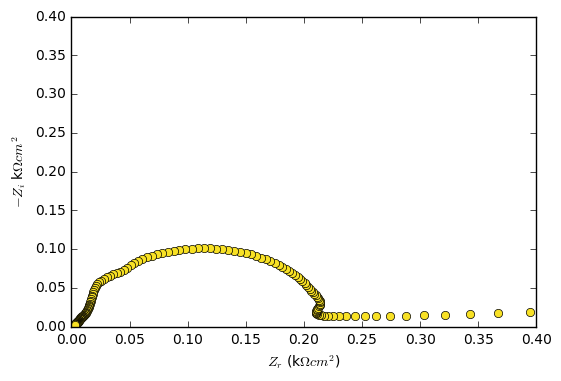

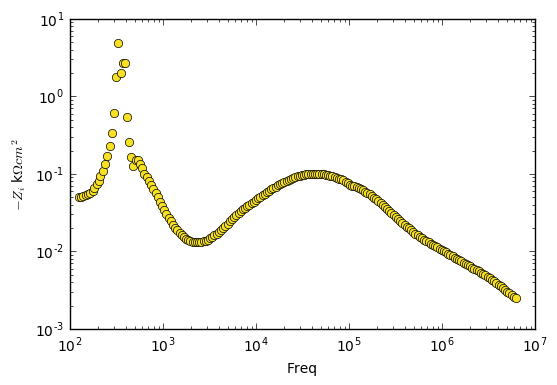

In [51]:
# inspect the plots by temperature to see where we should cut the data off 

tstar = 17

# Nyquist plots
fig,ax = plt.subplots(1,1)
# for t,c in zip(range(11,tmax),colSet):
ax.plot(Zr400(tstar),-Zi400(tstar),'o',color = tuple(colSet[tstar]))
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,.4, 0,0.4])
# plt.savefig('nyquist_all_zoom.png')


fig,ax = plt.subplots(1,1)
# for t,c in zip(range(11,tmax),colSet):
ax.plot(w(tstar),abs(-Zi400(tstar)),'o', color = tuple(colSet[tstar]))
ax.set_xlabel("Freq")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.axis([0,5, 0,1])
# plt.savefig('nyquist_all_zoom.png')

Simply by eye, this data looks a lot more like it indicates 1 broad distibution of time constants...

...at least for most of the data. Like we suspected from analyzing cases where the TAS data shows clear separation between the capacitance behavior of PbS and that of ZnO, this data seems to show that, at **lower** temperatures (say, below room temperature or thereabouts), there is 1 broad distibution of RC time constants dominating the kinetics. 

At higher temperatures, we again see a shoulder grow into the imaginary part of the data at slightly higher frequencies than the main RC arc. We also see evidence of a higher frequency impedance arc at temperatures above RT. 

So, let's go ahead and run the analysis on this data and see what shakes out. 

In [66]:
print(T[offSet:])

[ 220.  230.  240.  250.  260.  270.  280.  290.  300.  310.  320.  330.]


11
[ 26.  26.  30.  38.  45.  52.  58.  58.  65.  65.  68.  68.]
(12,)


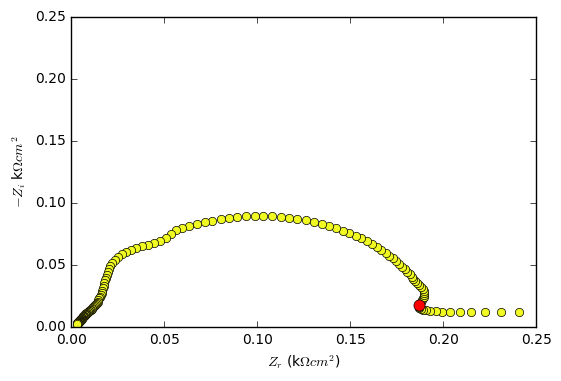

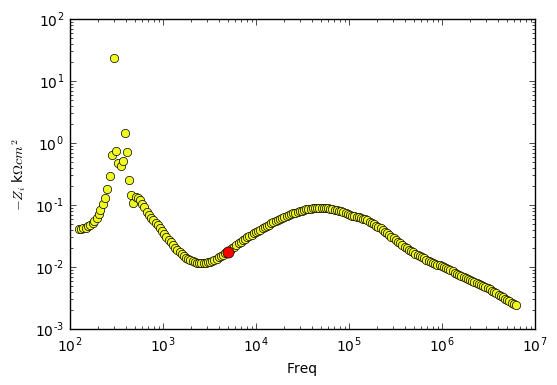

In [67]:
# clumsy way of ID-ing physically reasonable range of fit

# hardcode the offset obtained by visual inspection. We start the fits here; i.e. offSet becomes index 0 in bounds array. 
offSet = 7

bounds1 = np.zeros((tmax-offSet))
# bounds2 = np.zeros((16-13)+1)


Tt = 18
iguess = 68


fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt),-Zi400(Tt),'o', color = tuple(colSet[Tt]))
ax.plot(Zr400(Tt)[iguess],-Zi400(Tt)[iguess],'ro', markersize = 8)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,.25, 0,.25])

fig,ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[iguess],-Zi400(Tt)[iguess],'ro', markersize = 8)
ax.set_xlabel("Freq")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.set_xscale("log") 
ax.set_yscale("log") 

bounds1[0] = 26
bounds1[1] = 26
bounds1[2] = 30
bounds1[3] = 38
bounds1[4] = 45
bounds1[5] = 52
bounds1[6] = 58
bounds1[7] = 58
bounds1[8] = 65
bounds1[9] = 65
bounds1[10] = 68
bounds1[11] = 68

# check index of bounds array that should be filled and array thus far
print(Tt - offSet)
print(bounds1)
print(bounds1.shape)

# bounds2[1] = 
# bounds2[2] = 
# bounds2[3] = 
# bounds2[4] = 


Clearly, the model will fit less well to the high temperature data. It's almost like this data set is a nice transition between the 2 regimes. 

Let's go ahead and start the fits

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


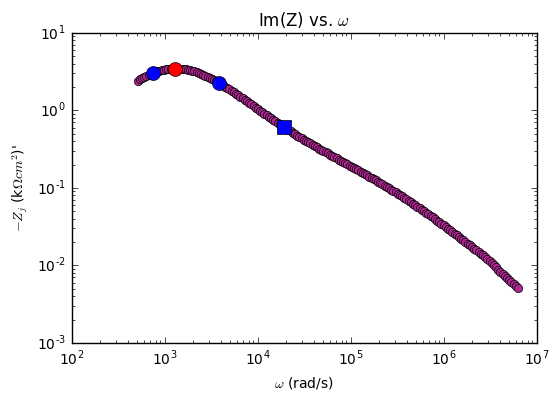

In [68]:
# Extract \alpha from the slope of the Im(z) vs. \omega.



# First obtain the bounds by inspection
fig, ax = plt.subplots(1,1)
ax.plot(w(offSet)[bounds1[0]:],abs(-Zi400(offSet)[bounds1[0]:]),'o', color = tuple(colSet[offSet]))
ax.plot(w(offSet)[43],abs(-Zi400(offSet)[43]),'ro',markersize = 10)
ax.plot(w(offSet)[43 + 20],abs(-Zi400(offSet)[43 + 20]),'bo',markersize = 10)
ax.plot(w(offSet)[43 + 50],abs(-Zi400(offSet)[43 + 50]),'bs',markersize = 10)
ax.plot(w(offSet)[43 - 10],abs(-Zi400(offSet)[43 - 10]),'bo',markersize = 10)
# ax.plot(w(5)[20 + 30],abs(-Zi(5)[20 + 30]),'bs',markersize = 10)
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-Z_{j}$ (k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([0,1]);
# plt.savefig('imZlogLTslope.png')

p1Guess = 43
bAlpha1 = np.array([63, 93])


-0.823409980722 7.62836672785
124 0.000382230719715


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


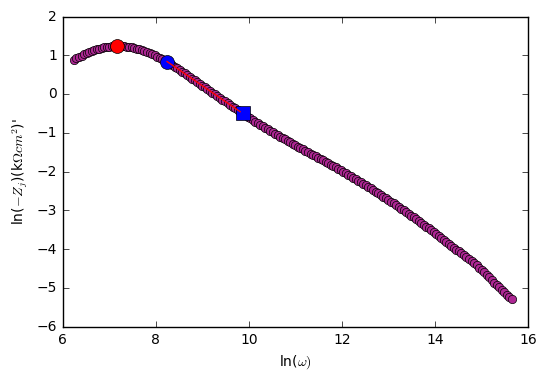

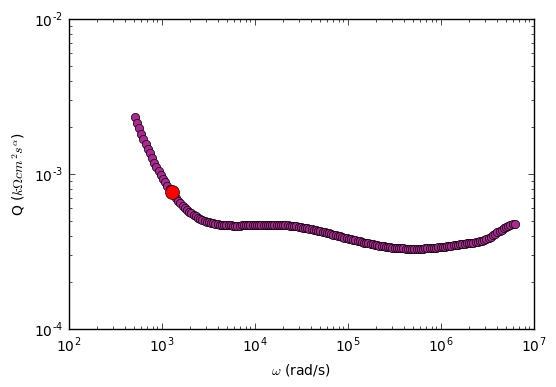

In [69]:
# since the peak appears at such low frequency, let's obtain a guess of \alpha by fitting the positive side of the distribution
x1 = np.vstack( [np.log(w(offSet)[bAlpha1[0]:bAlpha1[1]]), np.ones(len(w(offSet)[bAlpha1[0]:bAlpha1[1]]))]).T
y1 = np.log(abs(Zi400(offSet)[bAlpha1[0]:bAlpha1[1]]))
m1,c1 = np.linalg.lstsq(x1,y1)[0]
print(m1,c1)

# First obtain the bounds by inspection
fig, ax = plt.subplots(1,1)
ax.plot(np.log(w(offSet)[bounds1[0]:]),np.log(abs(-Zi400(offSet)[bounds1[0]:])),'o', color = tuple(colSet[offSet]))
ax.plot(np.log(w(offSet)[p1Guess]),np.log(abs(-Zi400(offSet)[p1Guess])),'ro',markersize = 10)
ax.plot(np.log(w(offSet)[bAlpha1[0]]),np.log(abs(-Zi400(offSet)[bAlpha1[0]])),'bo',markersize = 10)
ax.plot(np.log(w(offSet)[bAlpha1[1]]),np.log(abs(-Zi400(offSet)[bAlpha1[1]])),'bs',markersize = 10)
ax.plot(np.log(w(offSet)[bAlpha1[0]:bAlpha1[1]]), m1*np.log(w(offSet)[bAlpha1[0]:bAlpha1[1]]) + c1, 'r')
ax.set_xlabel("ln($\omega)$")
ax.set_ylabel("ln($-Z_{j}$)(k$\Omega cm^{2}$)'")
# ax.set_xscale("log") 
# ax.set_yscale("log") 
#ax.set_xlim([0,1]);
# ax.set_ylim([0,1]);
# figName = '\\imZlogLTslope.png'
# plt.savefig(figDir + figName,dpi = 300)


# save the slope as the alpha guess. calculate Q_{eff}
alphaG1 = abs(m1)

Qarray = np.sin((alphaG1*np.pi)/2)*(-1/(Zi400(offSet)*w(offSet)**(alphaG1)))

fig, ax = plt.subplots(1,1)
ax.plot(w(offSet)[:],Qarray[:],'o', color= tuple(colSet[offSet]))
ax.plot(w(offSet)[p1Guess],Qarray[p1Guess],'ro', markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("Q ($k \Omega cm^{2} s^{\\alpha}$)")
ax.set_xscale("log") 
ax.set_yscale("log")
# ax.set_title("Q vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# plt.savefig('Q_LT.png')
# figName = '\\Q_LT.png'
# plt.savefig(figDir + figName,dpi = 300)


wEff = np.argmax(w(5) > 1e5)
Qguess = Qarray[wEff]
print(wEff,Qguess)


Now we have the following parameter guesses for the lowest tempeature we want to analyze:

1) $\alpha \approx 0.82$

2) $Q_{eff} \approx 3.8\times 10^{-4}k\Omega^{-1} cm^{-2} s^{\alpha}$

Qualitatively, these numbers are much closer to what we expect than the goofy looking new data. Let's now define our fit and plug this in for the initial parameter estimates.

In [70]:
# set up the objective function using the lmfit pacakge. The objective function we are defining in this case are the residuals
# for both the real and imaginary parts of Z. A single array of both real and imaginary residuals is sent to lmfit, which
# then mnimizes the sum of the square of this array.

def circuitModelQ(w,Rs,Rct,Q,alpha):
    return Rs+(Rct/(1+((1j*w)**alpha)*Q*Rct))

def circuitResidQ(params,w,Zr,Zi):
    parvals = params.valuesdict()
    Rs = parvals['Rs']
    Rct = parvals['Rct']
    Q = parvals['Q']
    alpha = parvals['alpha']
    ZrHat = np.real(circuitModelQ(w,Rs,Rct,Q,alpha))
    ZiHat = np.imag(circuitModelQ(w,Rs,Rct,Q,alpha))
    resid1 = ZrHat-Zr
    resid2 = ZiHat-Zi
    return np.concatenate((resid1,resid2))

Parameters([('Rs', <Parameter 'Rs', value=0.052522097921159361 +/- 0.00384, bounds=[0:100]>), ('Rct', <Parameter 'Rct', value=7.6920609095705306 +/- 0.0241, bounds=[0:1000.0]>), ('Q', <Parameter 'Q', value=0.00016775038060948266 +/- 2.52e-06, bounds=[0:0.1]>), ('alpha', <Parameter 'alpha', value=0.92804767880337991 +/- 0.00202, bounds=[0:1]>)])
220.0


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


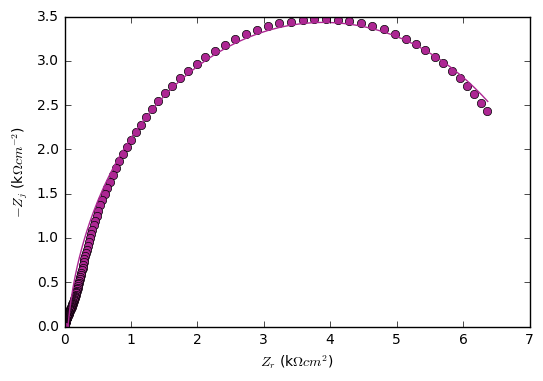

In [71]:
# add paramter estimates to the fit function
params = lmf.Parameters() 
params.add('Rs',value = 1, min = 0, max = 100)
params.add('Rct',value = 1, min = 0, max = 1e3)
params.add('Q',value = Qguess, min = 0, max = 1e-1)
params.add('alpha',value = alphaG1 , min = 0, max = 1)

# empty arrays for storing fit parameters
RsFits = []
RctFits = []
QFits = []
alphaFits =[]

# run the fit
fit = lmf.minimize(circuitResidQ,params,args = (w(offSet)[bounds1[0]:],Zr400(offSet)[bounds1[0]:],Zi400(offSet)[bounds1[0]:]))
RsFits.append(fit.params['Rs'].value)
RctFits.append(fit.params['Rct'].value)
QFits.append(fit.params['Q'].value)
alphaFits.append(fit.params['alpha'].value)
fit.params

print(fit.params)
# print(t+offSet)
print(T[offSet])

# plot the resulting fit
fig,ax = plt.subplots(1,1)
ax.plot(Zr400(offSet)[bounds1[0]:],-Zi400(offSet)[bounds1[0]:],'o',color = tuple(colSet[offSet]))
ax.plot(np.real(RsFits[0]+(RctFits[0]/(1+((1j*w(offSet)[bounds1[0]:])**alphaFits[0])*QFits[0]*RctFits[0]))),-np.imag(RsFits[0]+(RctFits[0]/(1+((1j*w(offSet)[bounds1[0]:])**alphaFits[0])*QFits[0]*RctFits[0]))),color = tuple(colSet[offSet]))     
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{j}$ (k$\Omega cm^{-2}$)")    
# figName = '\\nyquist_fit_'+ np.array2string(T[offSet].astype(int)) + '.png'
# plt.savefig(figDir + figName,dpi = 300)

In [72]:
print(RctFits)
print(type(RctFits))

[7.6920609095705306]
<class 'list'>


...aaand it's a pretty good fit. Not *perfect*, but certainly much better than what we were able to get out of the newer, what I'll refer to as 'double layer' data. 

Proceed with the rest of the fits!

In [58]:
print(bounds1.shape[0])

print(tmax-offSet+1)

print(t+offSet-1)

# print(T[t+offSet])

print(T)

13
13
24
[ 150.  160.  170.  180.  190.  200.  210.  220.  230.  240.  250.  260.
  270.  280.  290.  300.  310.  320.  330.]


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Parameters([('Rs', <Parameter 'Rs', value=0.038062094470839303 +/- 0.00257, bounds=[0:5]>), ('Rct', <Parameter 'Rct', value=4.3286000948950356 +/- 0.0107, bounds=[0:100]>), ('Q', <Parameter 'Q', value=0.00017115007784669828 +/- 2.61e-06, bounds=[0:0.001]>), ('alpha', <Parameter 'alpha', value=0.93363198950466098 +/- 0.00196, bounds=[0:1]>)])
1
8
230.0
Parameters([('Rs', <Parameter 'Rs', value=0.02709511556609645 +/- 0.00168, bounds=[0:5]>), ('Rct', <Parameter 'Rct', value=2.5062724798085134 +/- 0.00574, bounds=[0:100]>), ('Q', <Parameter 'Q', value=0.00017722923694066673 +/- 2.9e-06, bounds=[0:0.001]>), ('alpha', <Parameter 'alpha', value=0.93552760715669914 +/- 0.00199, bounds=[0:1]>)])
2
9
240.0
Parameters([('Rs', <Parameter 'Rs', value=0.018661839180364181 +/- 0.00108, bounds=[0:5]>), ('Rct', <Parameter 'Rct', value=1.3672258416155159 +/- 0.00328, bounds=[0:100]>), ('Q', <Parameter 'Q', value=0.0001812730099282779 +/- 3.46e-06, bounds=[0:0.001]>), ('alpha', <Parameter 'alpha', value

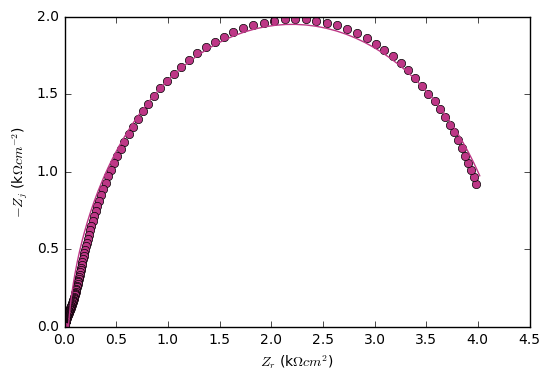

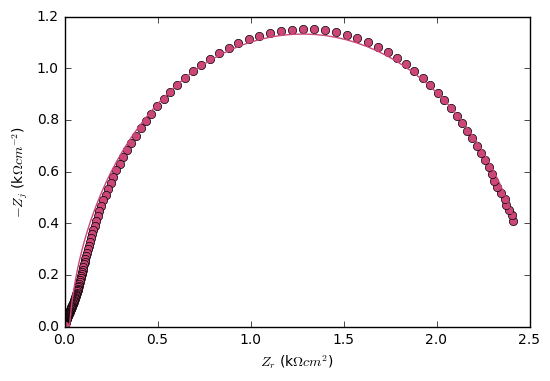

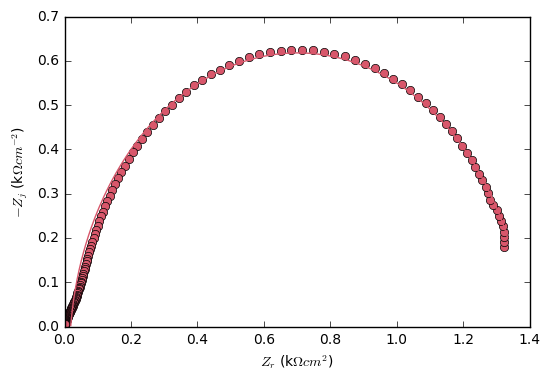

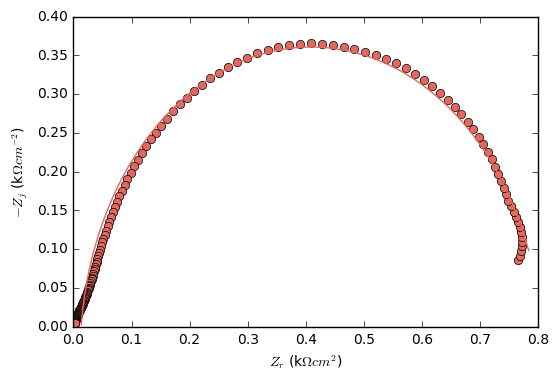

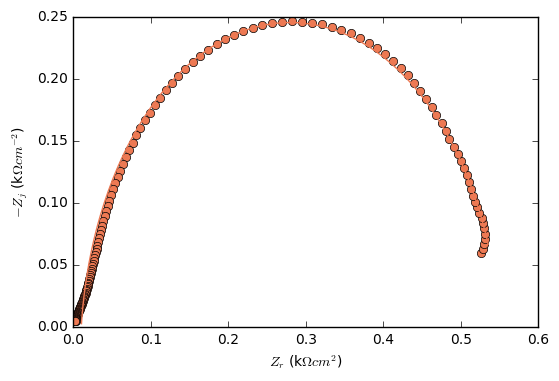

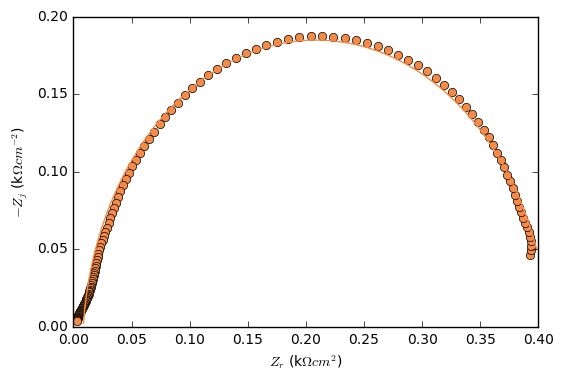

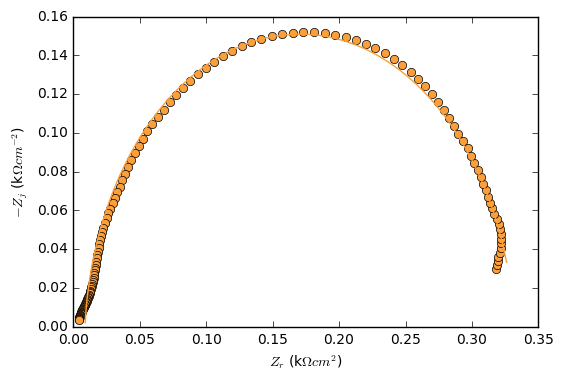

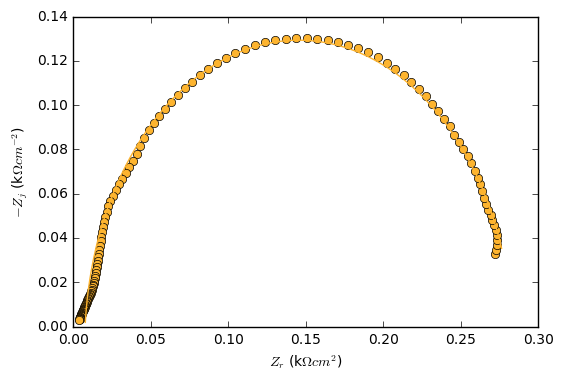

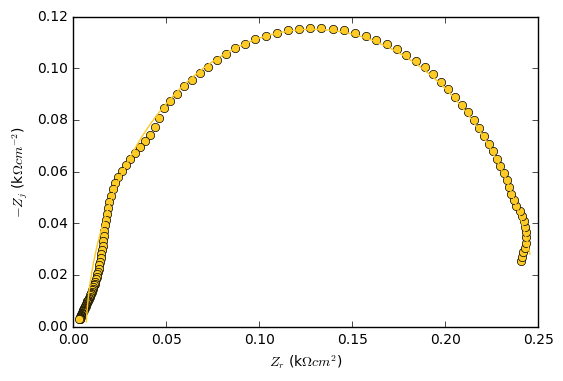

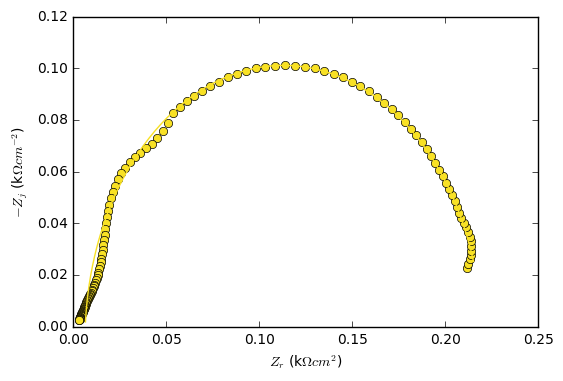

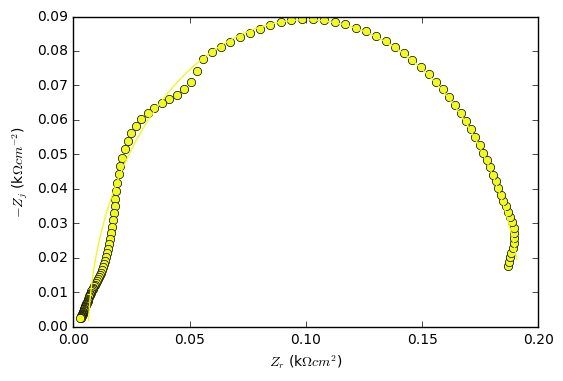

In [73]:
# run the next fit in a loop

for t in range(1,bounds1.shape[0]):
# for t in range(1,5):
    params = lmf.Parameters() 
    params.add('Rs',value = RsFits[t-1], min = 0, max = 5)
    params.add('Rct',value = RctFits[t-1], min = 0, max = 100)
    params.add('Q',value = QFits[t-1], min = 0, max = 1e-3)
    params.add('alpha',value = alphaFits[t-1] , min = 0, max = 1)

    # run the fit
    fit = lmf.minimize(circuitResidQ,params,args = (w(t+offSet)[bounds1[t]:],Zr400(t+offSet)[bounds1[t]:],Zi400(t+offSet)[bounds1[t]:]))
    RsFits.append(fit.params['Rs'].value)
    RctFits.append(fit.params['Rct'].value)
    QFits.append(fit.params['Q'].value)
    alphaFits.append(fit.params['alpha'].value)
    fit.params

    print(fit.params)
    print(t)
    print(t+offSet)
    print(T[t+offSet])
    # plot the resulting fit
    fig,ax = plt.subplots(1,1)
    ax.plot(Zr400(t+offSet)[bounds1[t]:],-Zi400(t+offSet)[bounds1[t]:],'o',color = tuple(colSet[t+offSet]))
    ax.plot(np.real(RsFits[t]+(RctFits[t]/(1+((1j*w(t+offSet)[bounds1[t]:])**alphaFits[t])*QFits[t]*RctFits[t]))),-np.imag(RsFits[t]+(RctFits[t]/(1+((1j*w(t+offSet)[bounds1[t]:])**alphaFits[t])*QFits[t]*RctFits[t]))),color = tuple(colSet[t+offSet]))     
    ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
    ax.set_ylabel("$-Z_{j}$ (k$\Omega cm^{-2}$)")    
#     figName = '\\nyquist_fit_'+ np.array2string(T[t+offSet].astype(int)) + '.png'
#     plt.savefig(figDir + figName,dpi = 300)
    

Great. As mentioned above, clearly we need to add in more terms for the higher temperature data to better capture the high frequency features. But, to first order, let's say that based on this data, we have failed to disprove our hypothesis. A more powerful confirmation of our hypothesis would come from being able to add in a term (or more) and obtaining better fits to the data. 

Anywho, for completeness sake, let's go ahead and extract the interesting lifetime parameters and activation energies.

0
220.0
1
230.0


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


2
240.0
3
250.0
4
260.0
5
270.0
6
280.0
7
290.0
8
300.0
9
310.0
10
320.0
11
330.0


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


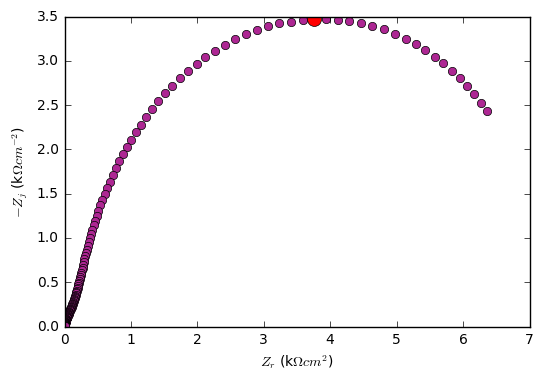

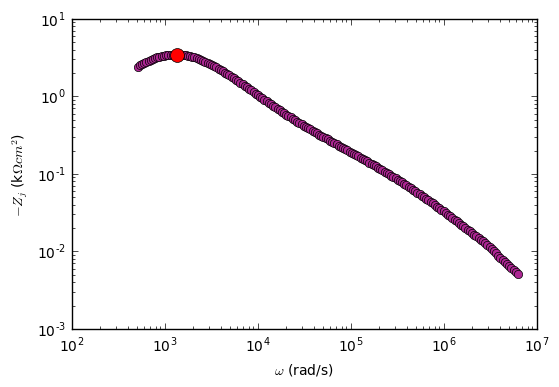

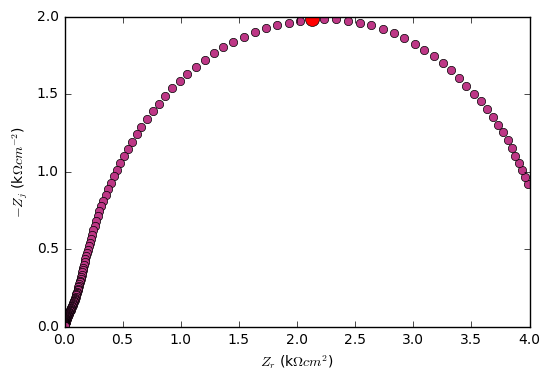

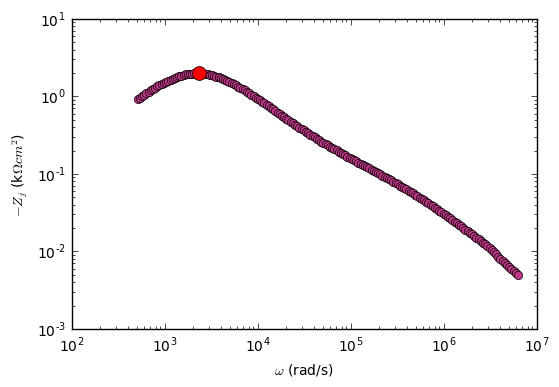

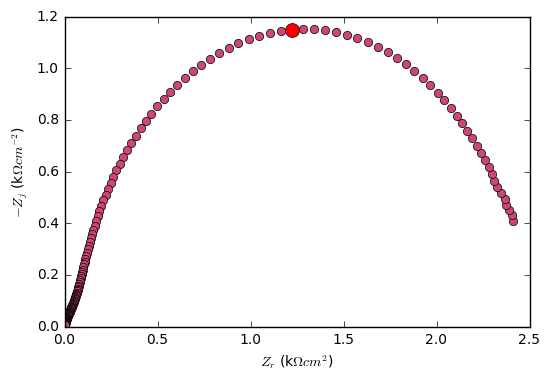

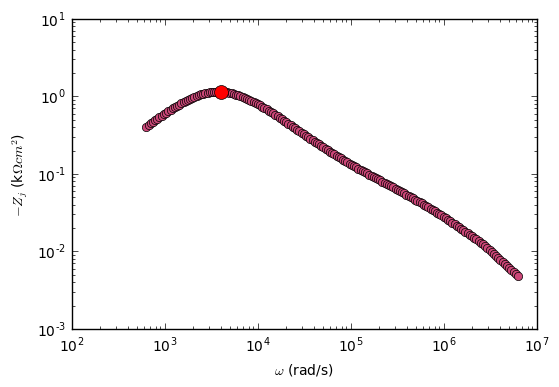

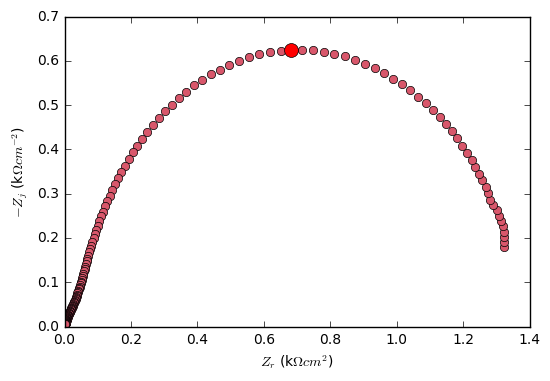

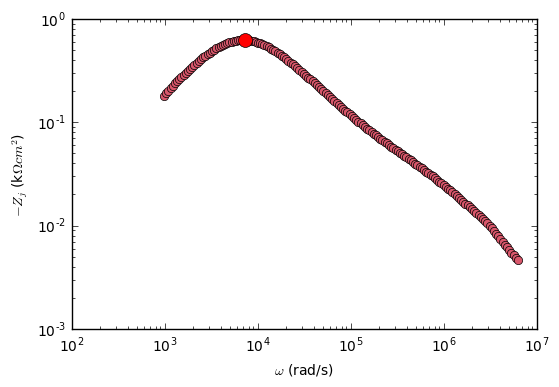

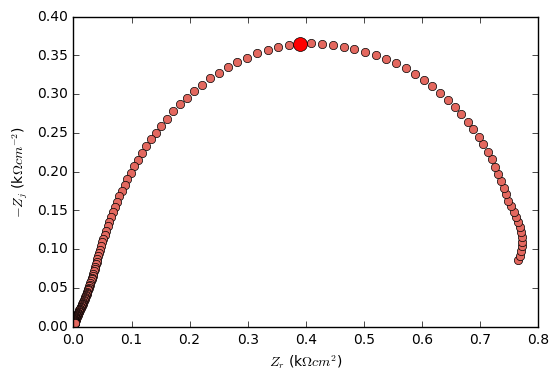

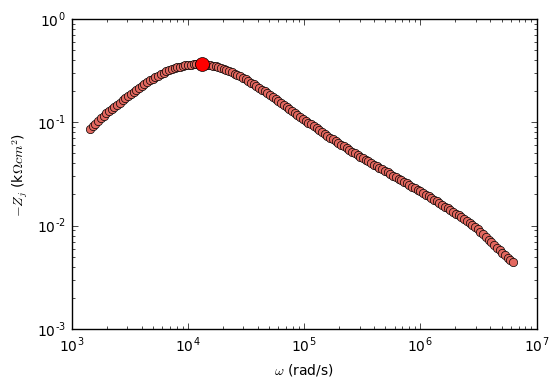

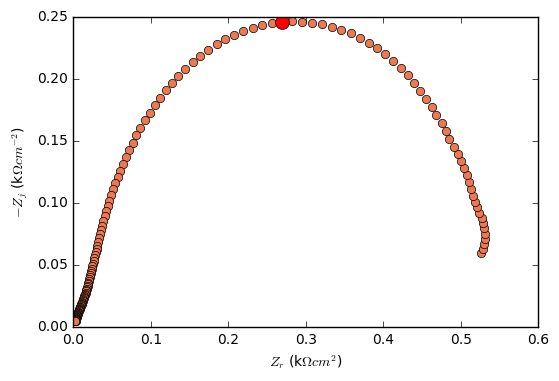

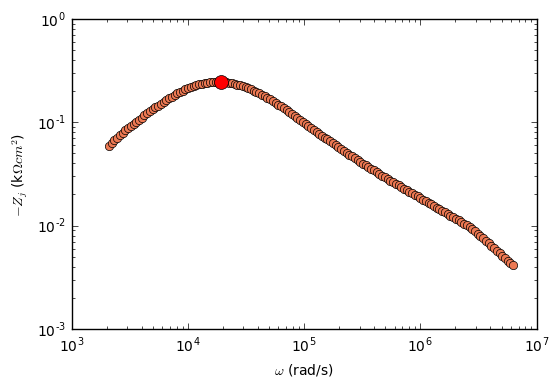

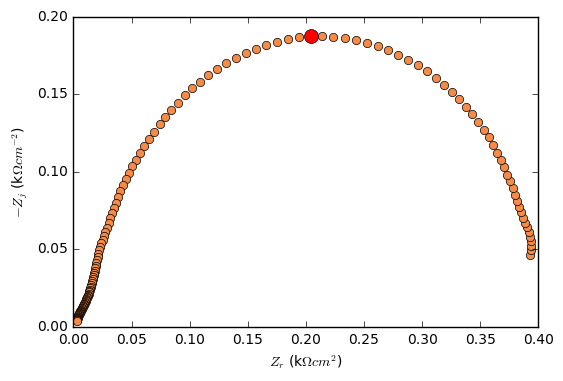

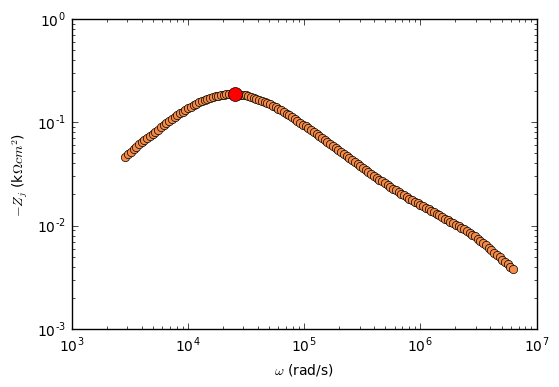

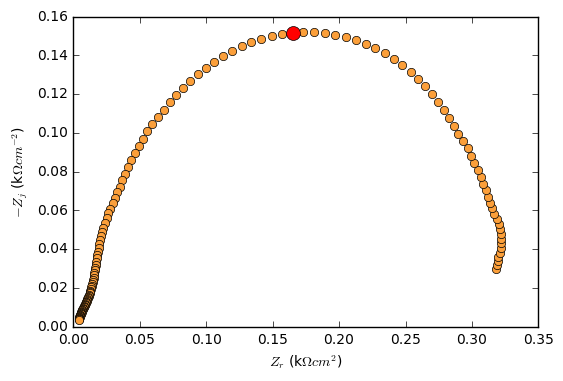

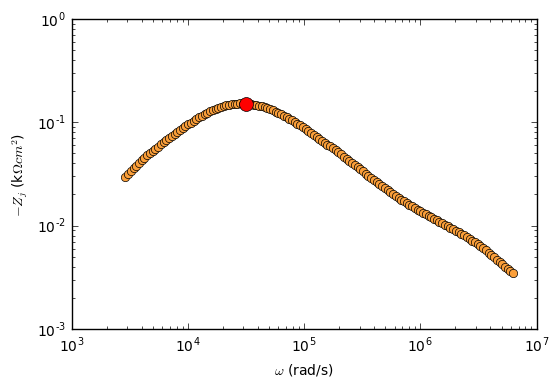

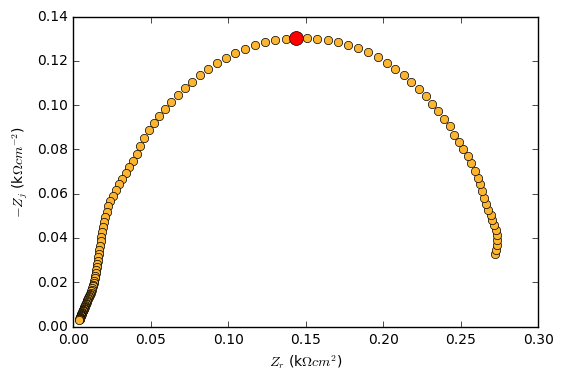

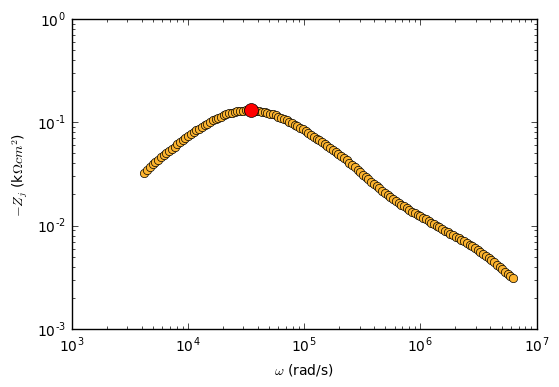

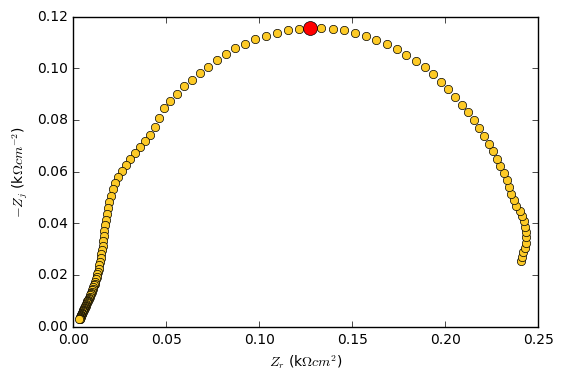

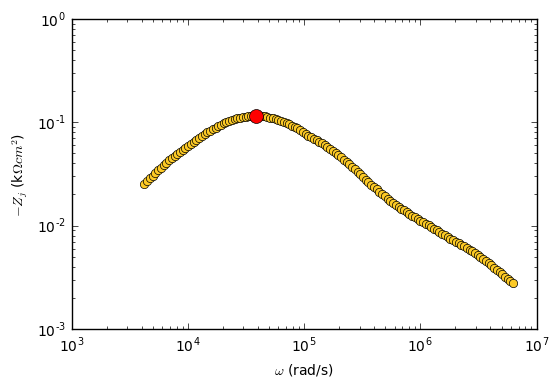

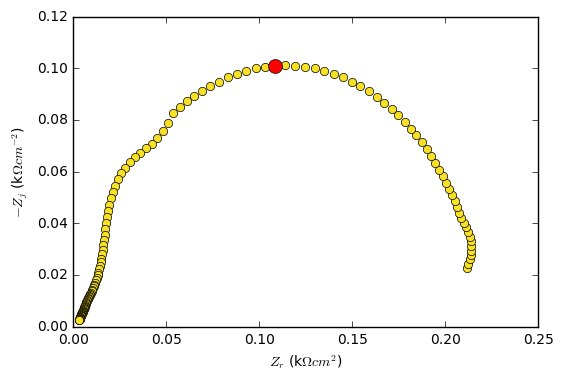

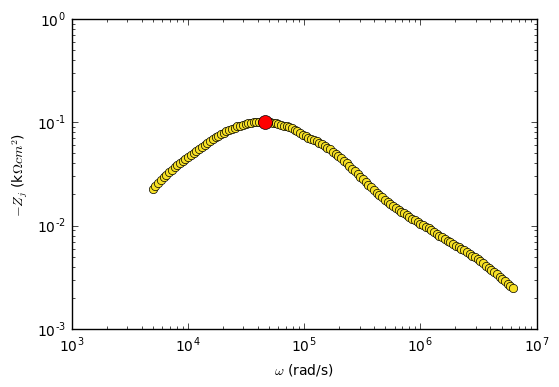

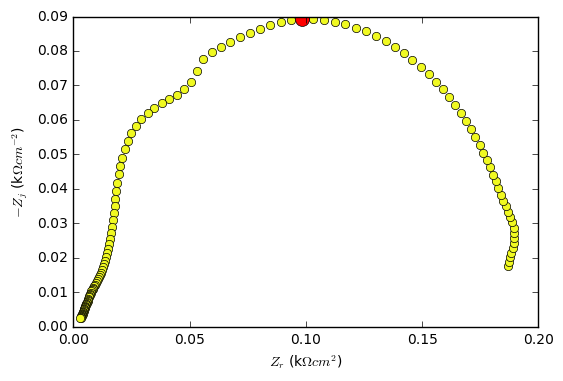

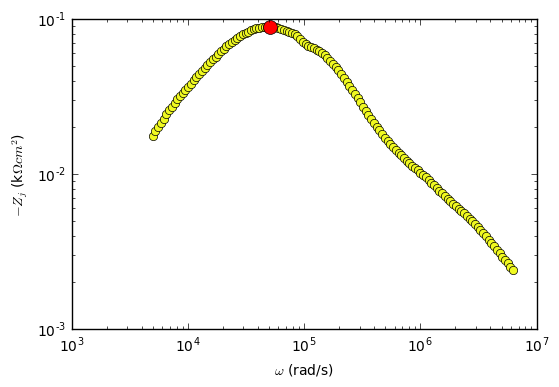

In [74]:
# calculate \tau from the RQ time constants like we did in the kinetic outline ipynb

# first make all the fit parameters np arrays to keep track of the data types
alphaFits = np.asarray(alphaFits)
QFits = np.asarray(QFits)
RsFits = np.asarray(RsFits)
RctFits = np.asarray(RctFits)

# now do the calculation. obtain both tau and the index of w0
tau = np.zeros(tmax-offSet)
wt0 = np.zeros(tmax-offSet)
for t in range(0,bounds1.shape[0]):
    tau[t] = [QFits[t]*RctFits[t]]**(1/alphaFits[t])
    wt0[t] = np.argmax(w(t+offSet) > (1/tau[t]))
    
    print(t)
    print(T[t+offSet])
    fig,ax = plt.subplots(1,1)
    ax.plot(Zr400(t+offSet)[bounds1[t]:],-Zi400(t+offSet)[bounds1[t]:],'o',color=tuple(colSet[t+offSet]))
    ax.plot(Zr400(t+offSet)[wt0[t]],-Zi400(t+offSet)[wt0[t]],'ro', markersize = 10)
    ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
    ax.set_ylabel("$-Z_{j}$ (k$\Omega cm^{-2}$)")
#     figName = '\\nyquist_tau_'+ np.array2string(T[t+offSet].astype(int)) + '.png'
#     plt.savefig(figDir + figName,dpi = 300)
    
    fig, ax = plt.subplots(1,1)
    ax.plot(w(t+offSet)[bounds1[t]:],abs((-Zi400(t+offSet)[bounds1[t]:])),'o',color=tuple(colSet[t+offSet]))
    ax.plot(w(t+offSet)[wt0[t]],abs((-Zi400(t+offSet)[wt0[t]])),'ro', markersize = 10)
    ax.set_xlabel("$\omega$ (rad/s)")
    ax.set_ylabel("$-Z_{j}$ (k$\Omega cm^{2}$)")
    ax.set_xscale("log") 
    ax.set_yscale("log") 
#     ax.set_title("Im(Z) vs. $\omega$")
#     figName = '\\imZ_tau_'+ np.array2string(T[t+offSet].astype(int)) + '.png'
#     plt.savefig(figDir + figName,dpi = 300)


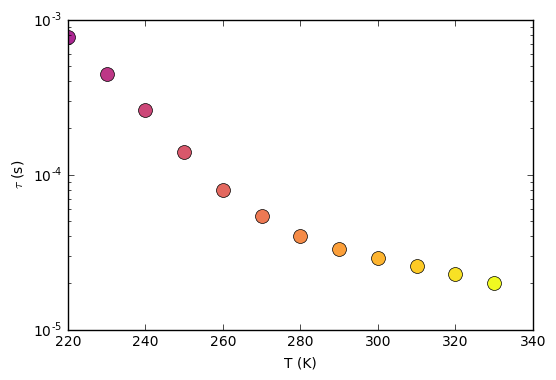

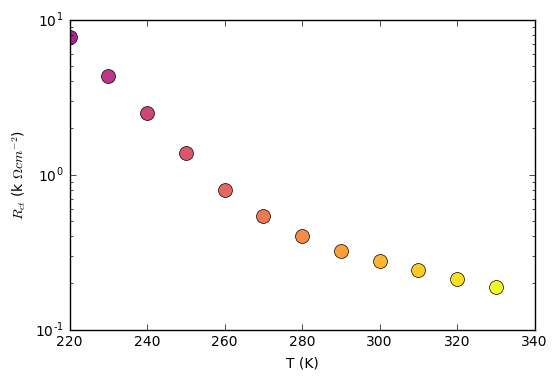

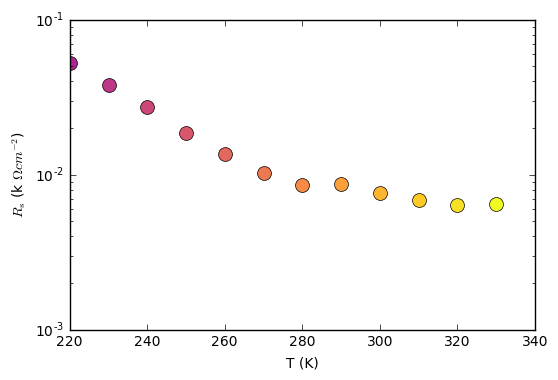

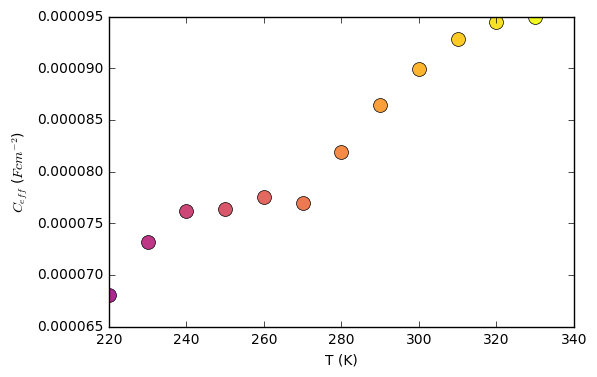

In [75]:
fig,ax = plt.subplots(1,1)
for t in range(0,bounds1.shape[0]):
    ax.plot(T[t+offSet],tau[t],'o',color=tuple(colSet[t+offSet]),markersize = 10)
ax.set_xlabel("T (K)")
ax.set_ylabel("$\\tau$ (s)")
ax.set_yscale('log')
#     plt.savefig('nyquistTau.png')

fig,ax = plt.subplots(1,1)
for t in range(0,bounds1.shape[0]):
    ax.plot(T[t+offSet],RctFits[t],'o',color=tuple(colSet[t+offSet]),markersize = 10)
ax.set_xlabel("T (K)")
ax.set_ylabel("$R_{ct}$ (k $\Omega cm^{-2}$)")
ax.set_yscale('log')
#     plt.savefig('nyquistTau.png')

fig,ax = plt.subplots(1,1)
for t in range(0,bounds1.shape[0]):
    ax.plot(T[t+offSet],RsFits[t],'o',color=tuple(colSet[t+offSet]),markersize = 10)
ax.set_xlabel("T (K)")
ax.set_ylabel("$R_{s}$ (k $\Omega cm^{-2}$)")
ax.set_yscale('log')


# also calculate the effective capacitance (according to Brug, et. al.) and see if this matches with our intuition of what's happening
Ceff = np.zeros(tmax-offSet)
for t in range(0,bounds1.shape[0]):
    Ceff[t] = [QFits[t]*((1/RsFits[t]) + (1/RctFits[t]))**(alphaFits[t]-1)]**(1/alphaFits[t])

fig,ax = plt.subplots(1,1)
for t in range(0,bounds1.shape[0]):
    ax.plot(T[t+offSet],Ceff[t],'o',color=tuple(colSet[t+offSet]),markersize = 10)
ax.set_xlabel("T (K)")
ax.set_ylabel("$C_{eff}$ ($F cm^{-2}$)")
# ax.set_yscale('log')

Interesting! There are very clearly 2 different regimes: a *high* temperature lifetime and a *low* temperature lifetime. The tipping point seems to be offset index 7 (global index 14, $T = 280$ K ). Sure enough, this is *precisely* where we see the disjoint in the 'FullTempAnalysis.ipynb' data as well. So, it points to some rather global behavior. 

Let's test how robust the overlay graphical method is. First, perform 1 fit to the data and try to overlay it. See what happens. Then, for the lifetime data only, try 2 fits and see what happens. Perhaps these are activation energies of the 2 layers...?

We should then go back to the older data and run 2 fits to compare. If it does indeed encompass the 2 layers, then let's see how close these energies are. That *might* tell us something about what $CdCl_{2}$ is doing to the trap energy and what the chemical origin of the trap is. It also might just be sample-to-sample variation at this point; kinda hard to tell. 

In [76]:
print(T[offSet:].shape)

print(tau.shape)

# RctFits = np.asarray(RctFits)
print(RctFits.shape)
print(type(RctFits))


(12,)
(12,)
(12,)
<class 'numpy.ndarray'>


2.46589300062 -18.6336174213
0.212485999863
0.215166799916


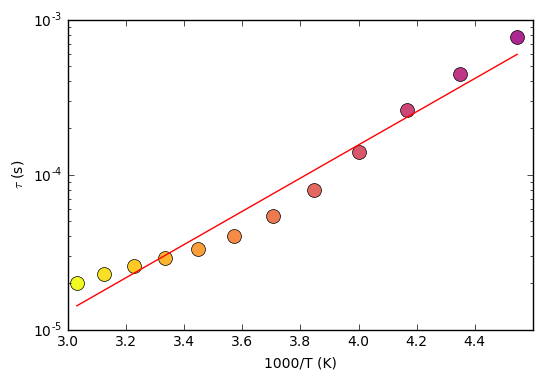

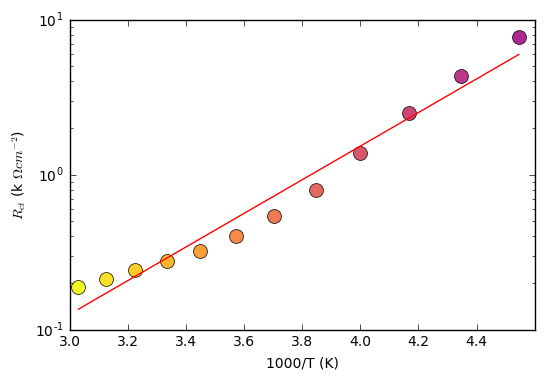

In [77]:
# now run the fits to \tau and to R_{ct}. they should be the same, but let's see what shakes out.

# first run the fit to \tau
xt = np.vstack( [1e3/T[offSet:], np.ones(len(T[offSet:]))] ).T
yt = np.log(tau[:])
mt,ct = np.linalg.lstsq(xt,yt)[0]
print(mt,ct)
Etau = ((kB*mt)*1e3)
print(Etau)
tauLine =  np.exp(mt*(1e3/T[offSet:])) * np.exp(ct)
# print(tauLine)


# now run the fit to R_{ct}
xr = np.vstack( [1e3/T[offSet:], np.ones(len(T[offSet:]))] ).T
yr = np.log(RctFits[:])
mr,cr = np.linalg.lstsq(xr,yr)[0]
# print(mr,cr)
Erct = ((kB*mr)*1e3)
print(Erct)
rctLine =  np.exp(mr*(1e3/T[offSet:])) * np.exp(cr)
# print(rctLine)

fig,ax = plt.subplots(1,1)
for t in range(0,bounds1.shape[0]):
    ax.plot(1e3/T[t+offSet],tau[t],'o',color=tuple(colSet[t+offSet]),markersize = 10)
#     ax.plot(1e3/T[t+offSet],tauLine[t], 'r')
ax.plot(1e3/T[offSet:],tauLine[:], 'r')
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$\\tau$ (s)")
ax.set_yscale('log')
# figName = '\\arrheniusTauLine_line1.png'
# plt.savefig(figDir + figName,dpi = 300)

fig,ax = plt.subplots(1,1)
for t in range(0,bounds1.shape[0]):
    ax.plot(1e3/T[t+offSet],RctFits[t],'o',color=tuple(colSet[t+offSet]),markersize = 10)
ax.plot(1e3/T[offSet:],rctLine[:], 'r')
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$R_{ct}$ (k $\Omega cm^{-2}$)")
ax.set_yscale('log')
# figName = '\\arrheniusRctLine_line1.png'
# plt.savefig(figDir + figName,dpi = 300)


Ah. So, it looks like the activation energy of the *total* series matches the activation energy I extract from the TAS measurement (more or less--I'll need to double check that, but I'm confident it was around $0.2 eV$). But look at the fit! It clearly encompases 2 different activation proceses. This is nice evidence for adding in more parameters to the model.

Let's try fitting 2 activation energies to the data. The physical intuition here is that one process dominates from $T = 220 - 270$ K, whereas a second process becomes dominant at $T > 280$ K. Of course, adding in parameters to our simple circuit model will give us a more complete picture of what's going on, but before I take a deep dive into that I just want to gain an intuituition for what's going on.

0.279311561729
0.108193525989


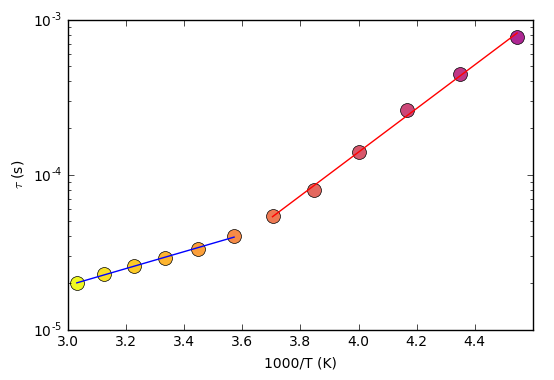

In [122]:
# extract index of critical temperature
idxC = np.where(T == 270.)[0][0]
# print(idxC)
# print(T[idxC])
idxTau = idxC - offSet + 1
# print(idxTau)
# print(tau[0:idxTau])

# print(T[offSet:idxC+1].shape[0])
# print(T[offSet:idxC+1])
# print(tau[:idxTau].shape[0])
# print(tau[:idxTau])

# print(T[idxC + 1:].shape[0])
# print(T[idxC + 1:])
# print(tau[idxTau:].shape[0])
# print(tau[idxTau:])
# print(tau)

# run the sub fits
xSub1 = np.vstack( [1e3/T[offSet:idxC+1], np.ones(len(T[offSet:idxC+1]))] ).T
ySub1 = np.log(tau[:idxTau])
mSub1,cSub1 = np.linalg.lstsq(xSub1,ySub1)[0]
# print(mSub1,cSub1)
EtauA = ((kB*mSub1)*1e3)
print(EtauA) 
tauLineA =  np.exp(mSub1*(1e3/T[offSet:idxC+1])) * np.exp(cSub1)

xSub2 = np.vstack( [1e3/T[idxC + 1:], np.ones(len(T[idxC + 1:]))] ).T
ySub2 = np.log(tau[idxTau:])
mSub2,cSub2 = np.linalg.lstsq(xSub2,ySub2)[0]
# print(mSub2,cSub2)
EtauB = ((kB*mSub2)*1e3)
print(EtauB) 
tauLineB =  np.exp(mSub2*(1e3/T[idxC + 1:])) * np.exp(cSub2)


fig,ax = plt.subplots(1,1)
for t in range(0,bounds1.shape[0]):
    ax.plot(1e3/T[t+offSet],tau[t],'o',color=tuple(colSet[t+offSet]),markersize = 10)

ax.plot(1e3/T[offSet:idxC+1],tauLineA, 'r')
ax.plot(1e3/T[idxC + 1:],tauLineB, 'b')

ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$\\tau$ (s)")
ax.set_yscale('log')
figName = '\\arrheniusTauLine_line2.png'
plt.savefig(figDir + figName,dpi = 300)

Interesting. So there is a low temperature, large activated process, and a shallow activation process at higher temperatures. Observationally, high temperatures are where we expect thecontribution of the ZnO to matter more (at leastin TAS), whereas at low temperatures we expect better separation of the 2 processes. 

So, let's say that at low temperature, the impedance properties are dominated by the PbS layer since it's *so* resistive. In this regime, we expect to see an activation energy corresponding to the PbS at $\approx 0.3$ eV. Whichis what we see!

At higher temperatures, the impedance of the PbS starts to approach the impedance of the ZnO. As such, we expect that defects in the ZnO start to influence the activation energy and lifetime we observe. So, perhaps this activation energy is something like the Fermi level offset between ZnO and PbS or something. 

In any event, it's clear that even in this samples, we need to add in more parameters to capture the low frequency PbS behavior. My guess is that the large lower frequency arc will continue the trend in the red line, whereas the emergent, high frequency arc will follow a trend a little closer to the blue line.